Internet Resources:

[Python Programming.net - machine learning episodes 1-11](https://pythonprogramming.net/machine-learning-tutorial-python-introduction/)

Linear regression finds the best possible linear equation that fits to the training data. 

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import quandl, math
from sklearn import preprocessing, svm, model_selection
from sklearn.linear_model import LinearRegression 
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

# getting data
if not os.path.isfile(os.path.abspath("data/wiki_googl.csv")):
    df = quandl.get("WIKI/GOOGL")
else:
    df = pd.read_csv("data/wiki_googl.csv")

# use date as index
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# only keep adjusted data 
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0 # HL_PCT High low percentage
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

df.fillna(value=-99999, inplace=True)

predict_lenght = int(math.ceil(0.1 * len(df))) # we are using 90% of the data to "train" our model and 10% to make predictions
predict_col = 'Adj. Close' # we want to predict the adj close price
df['label'] = df[predict_col].shift(-predict_lenght)
df

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0,214.005615
2004-08-20,54.322689,7.921706,7.227007,22834300.0,210.725489
2004-08-23,54.869377,4.049360,-1.227880,18256100.0,208.072299
2004-08-24,52.597363,7.657099,-5.726357,15247300.0,218.288837
2004-08-25,53.164113,3.886792,1.183658,9188600.0,223.309335
...,...,...,...,...,...
2018-03-21,1094.000000,1.964351,0.130884,1990515.0,NaN
2018-03-22,1053.150000,3.254997,-2.487014,3418154.0,NaN
2018-03-23,1026.550000,4.082607,-2.360729,2413517.0,NaN


In [2]:
# split and prepare data

# x = features
# y = labels

x = np.array(df.drop(['label'], 1)) # 1 denotes which axis
# mean value along the axis is subtracted from x and the resulting value 
# is divided by standard deviation along the axis.
# see https://scikit-learn.org/stable/modules/preprocessing.html
x = preprocessing.scale(x) 

x_predict = x[-predict_lenght:] # these are the last 10% of the data. We will use these to make predictions
# the predict data frame will hold our predicted values
predict_df = df.iloc[-predict_lenght:] # iloc: Purely integer-location based indexing for selection by position
predict_df = predict_df.rename(columns={"label":"Prediction"})

# getting our "training" data
x = x[:-predict_lenght]
df.dropna(inplace=True)
y = np.array(df["label"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)

predict_df

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,Prediction
Date,,,,,
2016-11-11,771.75,1.522514,-0.651382,3592641.0,NaN
2016-11-14,753.22,3.742598,-2.402301,3688274.0,NaN
2016-11-15,775.16,1.937355,1.265889,2943889.0,NaN
2016-11-16,779.98,2.201338,-0.237900,1798360.0,NaN
2016-11-17,786.16,1.151165,0.467732,1533679.0,NaN
...,...,...,...,...,...
2018-03-21,1094.00,1.964351,0.130884,1990515.0,NaN
2018-03-22,1053.15,3.254997,-2.487014,3418154.0,NaN
2018-03-23,1026.55,4.082607,-2.360729,2413517.0,NaN


In [5]:
# do linear regression

if os.path.exists('linearregression.pickle'):
    clf = pickle.load(open('linearregression.pickle','rb'))
else:
    clf = LinearRegression(n_jobs=-1) # do as many jobs as possible
    clf.fit(x_train, y_train) # fit/"train" to data
    with open('linearregression.pickle','wb') as f: # save classifier
        pickle.dump(clf, f)
    
accuracy = clf.score(x_test, y_test)
forecast = clf.predict(x_predict)

#print(forecast,accuracy, predict_lenght)
print(f"accuracy: {accuracy}")

accuracy: 0.8767021486362289


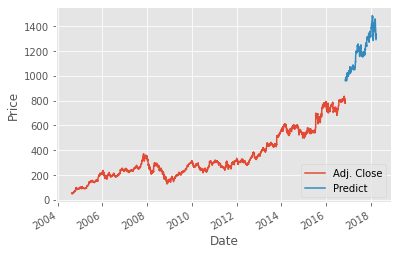

In [4]:
#plotting
style.use('ggplot')

predict_df["Predict"] = forecast

df['Adj. Close'].plot()
predict_df['Predict'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()